In [1]:
import os
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial import distance
from dataloader import get_dataset
from sam2.build_sam import build_sam2
from model.sam2lorabase import SAM2LoRABase
from model.sam2_image_predictor import SAM2ImagePredictor

from dictionaries import VESSEL_DATASET_DICT, DISC_DATASET_DICT

os.environ["TORCH_CUDNN_SDPA_ENABLED"] = "1"

from sklearn.metrics import confusion_matrix  
import numpy as np


: 

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(0)

In [ ]:
def compute_iou(y_pred, y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

def calculate_dice(y_pred, y_truth):
    return 1 - distance.dice(y_truth.flatten(), y_pred.flatten())

In [3]:
model_size = 'l'
lora_rank = 64
lora_alpha = 2* lora_rank
high_res  = True
model_config = f"configs/sam2.1/sam2.1_hiera_{model_size}.yaml"
MODELSIZE = {'l': 'large', 'b':'base', 's':'small'}
model = build_sam2(model_config, f"C:\\Users\\Sayan Mandal\\workspace\\segment-anything-2\\checkpoints\\sam2.1_hiera_{MODELSIZE[model_size]}.pt")
for param in model.parameters():
    param.requires_grad = False

sam_model = SAM2LoRABase(model, rank=lora_rank, alpha=lora_alpha,use_high_res_features_in_sam=high_res).to('cuda')
predictor = SAM2ImagePredictor(sam_model)

In [7]:
dataset_name = "optic_disc"
seg_type = "od"
rank = lora_rank
alpha=lora_alpha
checkpoint_path = f"checkpoints/rank{rank}/od/fundus_{dataset_name}_{seg_type}_sam2_l_r{rank}_a{alpha}_best.ckpt"
output_name = 'temp_out'
metrics = {}
if checkpoint_path and checkpoint_path.endswith('.ckpt'):
    checkpoint_dict =  torch.load(checkpoint_path)
    predictor.model.load_state_dict(checkpoint_dict['model_state_dict'])
else:
    model = build_sam2(model_config, f"C:\\Users\\Sayan Mandal\\workspace\\segment-anything-2\\checkpoints\\sam2.1_hiera_{MODELSIZE[model_size]}.pt")
    for param in model.parameters():
        param.requires_grad = False
    predictor = SAM2ImagePredictor(model)
    if not output_name:
        output_name = 'vanilla'
    else:
        output_name = output_name+'_vanilla'

In [91]:
eval_mode=1
if eval_mode == 0:
    prompt_type = 'none'
    num_pos_points = 0
    num_neg_points = 0
    num_boxes = 0
elif eval_mode == 1:
    prompt_type = 'point'
    num_pos_points =1
    num_neg_points = 0
elif eval_mode == 2:
    prompt_type = 'point'
    num_pos_points = 2
    num_neg_points = 0
elif eval_mode == 3:
    prompt_type = 'point'
    num_pos_points = 5
    num_neg_points = 0
elif eval_mode == 4:
    prompt_type = 'point'
    num_pos_points = 5
    num_neg_points = 1
elif eval_mode == 5:
    prompt_type = 'box'
elif eval_mode == 6:
    prompt_type = 'all'
    num_pos_points = 5
    num_neg_points = 1


region_type = 'density'

In [92]:
dataset_dict = {}
dataset_name = 'optic_disc'
if dataset_name in ['vessel']:
    for name in VESSEL_DATASET_DICT.keys():
        dataset_dict[name.lower()] = get_dataset(dataset_name = name.lower(), mode='test', seg_type=seg_type, transform=None, color_transform=None,
                                 num_pos_points = num_pos_points, num_neg_points = num_neg_points, num_boxes = 1, 
                                 region=region_type, random_state=0)

elif dataset_name in ['optic_disc']:
    for name in DISC_DATASET_DICT.keys():
        if name.lower() != 'idrid':
            dataset_dict[name.lower()] = get_dataset(dataset_name = name.lower(), mode='test', seg_type=seg_type, transform=None, color_transform=None,
                                    num_pos_points = num_pos_points, num_neg_points = num_neg_points, num_boxes = 1, 
                                    region=region_type, random_state=0)

elif dataset_name in ['chasedb1', 'drive', 'fives', 'hrf', 'stare','drishtigs', 'g1020', 'grape', 'idrid', 'origa', 'papiladb', 'refuge2']:
    dataset_dict[dataset_name] = get_dataset(dataset_name = dataset_name, mode='test', seg_type=seg_type, transform=None, color_transform=None,
                                 num_pos_points = num_pos_points, num_neg_points = num_neg_points, num_boxes = 1, 
                                 region=region_type, random_state=0)

In [93]:
DISC_DATASET_DICT.keys()

dict_keys(['DRISHTIGS', 'G1020', 'GRAPE', 'IDRID', 'ORIGA', 'PAPILADB', 'REFUGE2'])

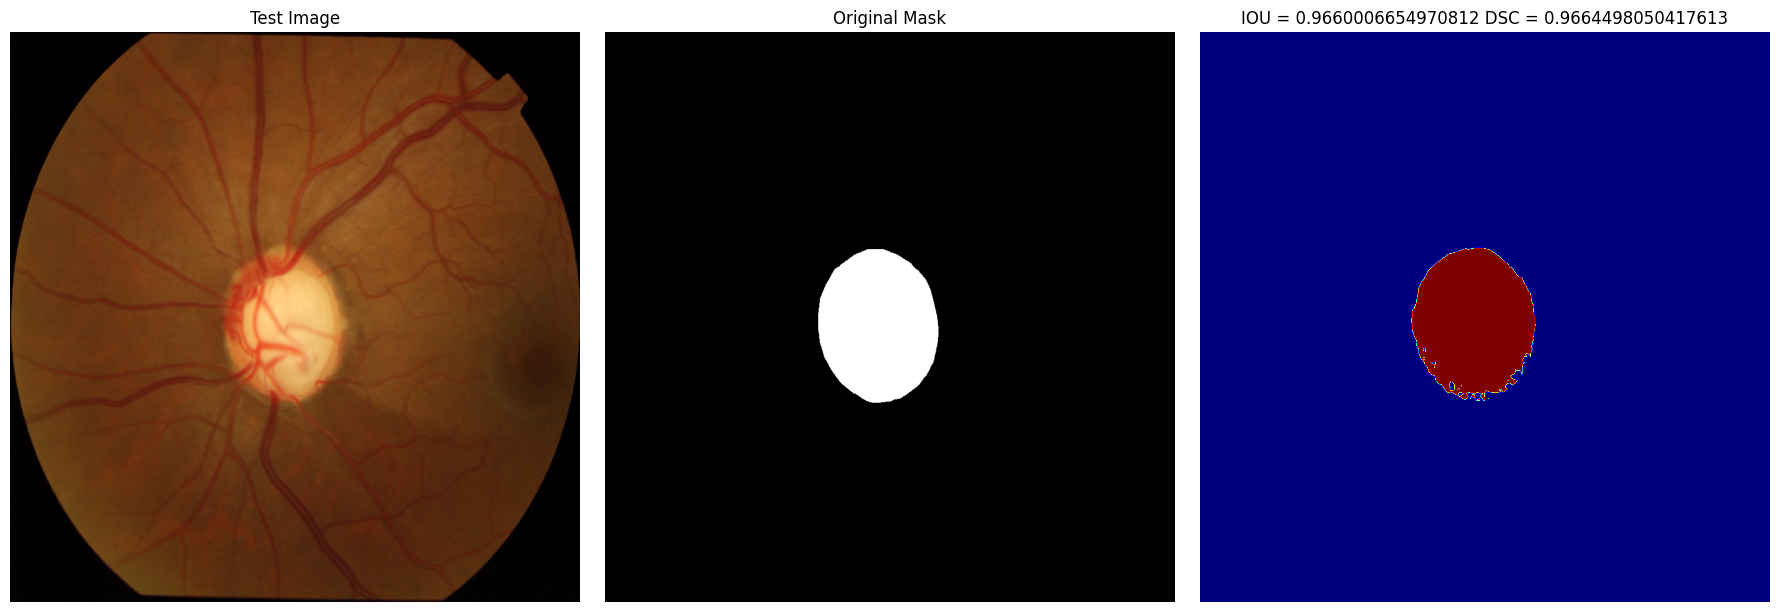

In [107]:
# Process the predicted masks and sort by scores
example_name = 'drishtigs'

images, gt_masks, pos_points, neg_points, boxes, num_masks = dataset_dict[example_name][6]

num_classes = min(gt_masks.shape[0],3)

pos_pts = np.array(pos_points)
neg_pts = np.array(neg_points)
box_pts = np.array(boxes)

if prompt_type.lower() == 'none':
    pos_pts = None
    neg_pts = None
    box_pts = None
elif prompt_type.lower() == 'point':
    box_pts = None
elif prompt_type.lower() == 'box':
    pos_pts = None
    neg_pts = None

if pos_pts is not None:
    input_label = np.array([1] * pos_pts.shape[0] + [0] * neg_pts.shape[0])
    input_points = np.concatenate((pos_pts, neg_pts), axis=0) if neg_pts.size > 0 else pos_pts
else:
    input_points, input_label = None, None

input_boxes = box_pts

if input_points is None and input_boxes is None and prompt_type.lower() != 'none':
    raise ValueError(f"Did not find input prompt for prompt type: {prompt_type}")

if metrics is None:
    metrics = {}

num_pos_pts = pos_pts.shape[0] if pos_pts is not None else 0
num_neg_pts = neg_pts.shape[0] if neg_pts is not None else 0
num_boxes = 1 if box_pts is not None else 0

with torch.no_grad():
    predictor.set_image(images)
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        box = input_boxes,
        multimask_output=True,
        return_logits = True,
    )

np_masks = np.array(masks[:num_classes])
np_scores = scores[:num_classes]


np_masks = np.array(masks)
np_scores = scores[:]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)


# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   _mask = sorted_masks[i]
   if (_mask * occupancy_mask).sum() / _mask.sum() > 0.15:
       continue

   mask_bool = _mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

gt_mask = gt_masks[0]
prd_mask = masks[0]
prd_mask = (prd_mask>0).astype(np.uint8)

iou = compute_iou(prd_mask, gt_mask)
dsc = calculate_dice(prd_mask, gt_mask)

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(images)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(gt_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f'IOU = {iou} DSC = {dsc}')
plt.imshow(prd_mask, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

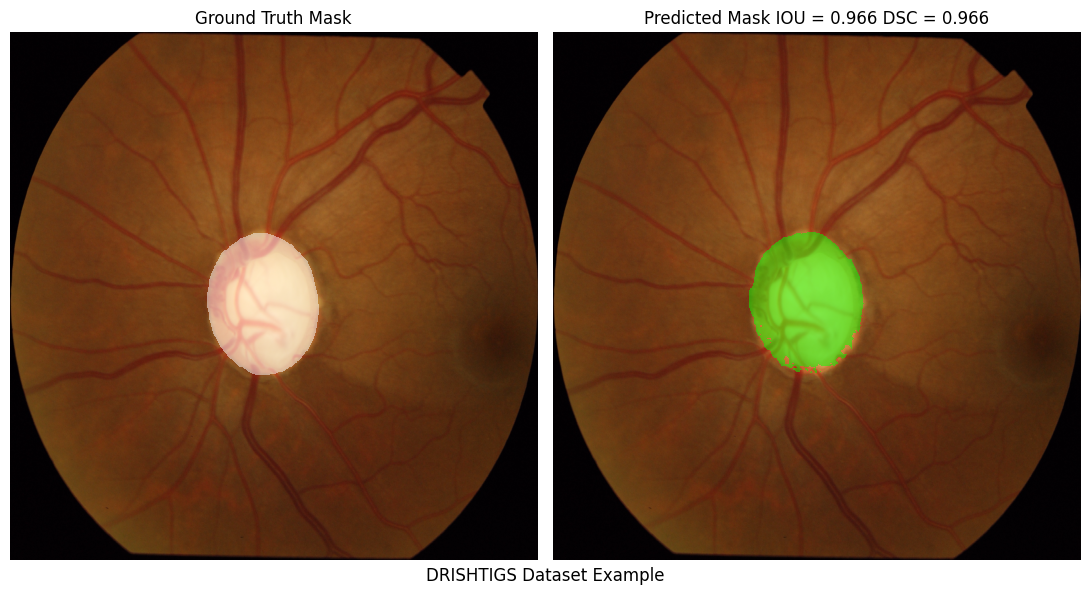

In [109]:
gt_mask_binary = (gt_mask > 0.5).astype(np.uint8)
prd_mask_binary = (prd_mask > 0.5).astype(np.uint8)

# Create custom colormaps:
# For the original (ground truth) mask: use a grayscale color for segmented parts
# For the predicted mask: use the 'jet' colormap color for the segmented parts
# In each colormap, index 0 (value 0) is fully transparent,
# and index 1 (value 1) gets a semi-transparent color (alpha=0.5)

# Custom colormap for ground truth mask overlay (e.g., light gray)
cmap_gt = ListedColormap([[0, 0, 0, 0], [1, 1, 1, 0.5]])

# For prediction: index 0 is transparent, index 1 is bright green with transparency.
cmap_prd = ListedColormap([[0, 0, 0, 0], [0, 1, 0, 0.5]])

# Create a figure with two subplots.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

# Plot ground truth overlay
ax1.imshow(images)
ax1.imshow(gt_mask_binary, cmap=cmap_gt, interpolation='none')
ax1.set_title('Ground Truth Mask')
ax1.axis('off')

# Plot predicted overlay
ax2.imshow(images)
ax2.imshow(prd_mask_binary, cmap=cmap_prd, interpolation='none')
ax2.set_title(f'Predicted Mask IOU = {iou:.3f} DSC = {dsc:.3f}')
ax2.axis('off')

# Add a main title at the bottom center with IOU and DSC values to 3 decimal places.
fig.text(0.5, 0.02, f"{example_name.upper()} Dataset Example", ha="center", fontsize=12)

# Adjust layout to leave space for the bottom title.
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(f"{example_name}_example.png", dpi=200)
plt.show()

In [9]:
import glob, os
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
imgs = glob.glob('./*_example.png')

In [16]:
vessel_img_paths = [f"./{name.lower()}_example.png" for name in VESSEL_DATASET_DICT.keys()]
disc_img_paths = [f"./{name.lower()}_example.png" for name in DISC_DATASET_DICT.keys() if 'idrid' not in name.lower()]

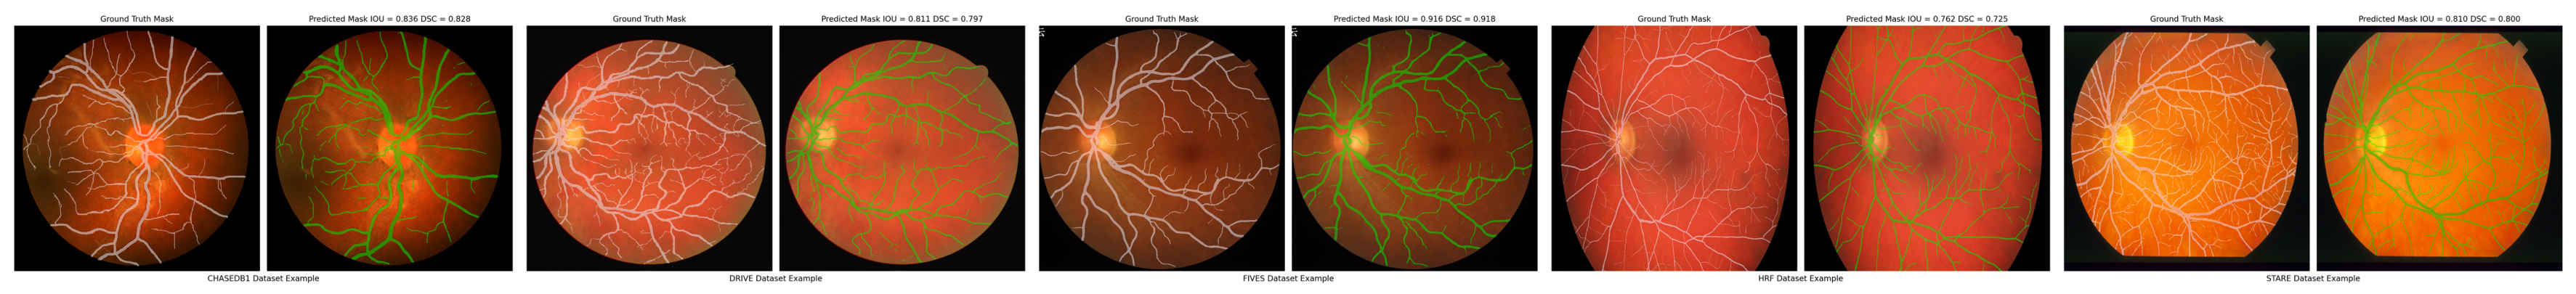

In [19]:
fixed_height = 500
img_paths = vessel_img_paths

# Load and resize images while preserving aspect ratio
resized_images = []
for path in img_paths:
    img = Image.open(path)
    # Calculate the new width to preserve the aspect ratio
    ratio = fixed_height / float(img.size[1])
    new_width = int(img.size[0] * ratio)
    img_resized = img.resize((new_width, fixed_height), Image.LANCZOS)
    resized_images.append(img_resized)

# Compute the total width needed for the combined image
total_width = sum(img.size[0] for img in resized_images)

# Create a new blank image (white background) to hold all images side by side
combined_img = Image.new('RGB', (total_width, fixed_height), (255, 255, 255))

# Paste each resized image into the combined image
x_offset = 0
for img in resized_images:
    combined_img.paste(img, (x_offset, 0))
    x_offset += img.size[0]

# Display the final combined image using matplotlib
plt.figure(figsize=(total_width/100, fixed_height/100))  # Adjusting figsize based on total dimensions
plt.imshow(combined_img)
plt.axis('off')
plt.savefig('vessel_example.png', dpi=200)
plt.show()

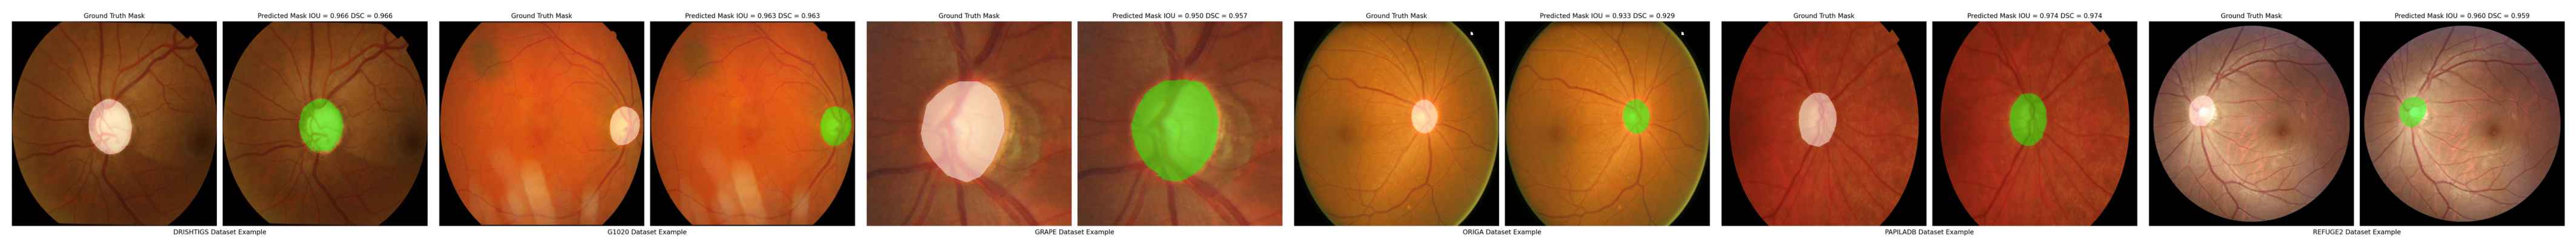

In [18]:
fixed_height = 500
img_paths = disc_img_paths

# Load and resize images while preserving aspect ratio
resized_images = []
for path in img_paths:
    img = Image.open(path)
    # Calculate the new width to preserve the aspect ratio
    ratio = fixed_height / float(img.size[1])
    new_width = int(img.size[0] * ratio)
    img_resized = img.resize((new_width, fixed_height), Image.LANCZOS)
    resized_images.append(img_resized)

# Compute the total width needed for the combined image
total_width = sum(img.size[0] for img in resized_images)

# Create a new blank image (white background) to hold all images side by side
combined_img = Image.new('RGB', (total_width, fixed_height), (255, 255, 255))

# Paste each resized image into the combined image
x_offset = 0
for img in resized_images:
    combined_img.paste(img, (x_offset, 0))
    x_offset += img.size[0]

# Display the final combined image using matplotlib
plt.figure(figsize=(total_width/100, fixed_height/100))  # Adjusting figsize based on total dimensions
plt.imshow(combined_img)
plt.axis('off')
plt.savefig('disc_example.png', dpi=200)
plt.show()